# Mixture Models


The previous notebook worked and used all features, though it has some issues. Because it has multiple likelihoods it is hard to evalutate the model and compare it to others. Furthermore there still is a requirement to set the desired number of clusters, we'll check here if we can use a Multivariate Gaussian to get a single likelihood and compare models generated with different cluster sizes to pick the optimal size.


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

import altair as alt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
penguin_df = (
    pd.read_csv("./data/penguins_size.csv").drop(columns=["island", "sex"]).dropna()
)
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


<IPython.core.display.Javascript object>

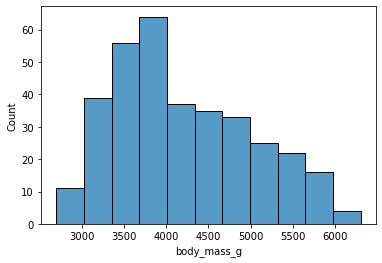

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(penguin_df.body_mass_g)

In [4]:
combined = (
    alt.Chart(penguin_df)
    .mark_bar(color="gray")
    .encode(x=alt.X("body_mass_g", bin=True, title="Body mass (g)"), y="count()")
)
per_species = (
    alt.Chart(penguin_df)
    .mark_bar()
    .encode(
        x=alt.X("body_mass_g", bin=True, title="Body mass (g)"),
        y="count()",
        color="species",
    )
)

(combined | per_species)

alt.HConcatChart(...)

<IPython.core.display.Javascript object>

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_penguin_df = scaler.fit_transform(penguin_df.drop(columns=["species"]))
scaled_penguin_df = pd.DataFrame(scaled_penguin_df, columns=penguin_df.columns[1:])
scaled_penguin_df["species"] = list(penguin_df["species"])
scaled_penguin_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,-0.884499,0.785449,-1.418347,-0.564142,Adelie
1,-0.811126,0.126188,-1.062250,-0.501703,Adelie
2,-0.664380,0.430462,-0.421277,-1.188532,Adelie
3,-1.324737,1.089724,-0.563715,-0.938776,Adelie
4,-0.847812,1.748985,-0.777373,-0.689020,Adelie
...,...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175,Gentoo
338,0.527932,-1.445897,1.003109,0.809516,Gentoo
339,1.188289,-0.735923,1.501644,1.933419,Gentoo
340,0.234440,-1.192335,0.789451,1.246590,Gentoo


<IPython.core.display.Javascript object>

In [6]:
scaled_penguin_df.groupby(["species"]).agg(
    mean_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="mean"),
    std_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="std"),
    mean_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="mean"),
    std_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="std"),
    mean_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="mean"),
    std_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="std"),
    mean_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="mean"),
    std_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="std"),
)

,mean_culmen_length,std_culmen_length,mean_culmen_depth,std_culmen_depth,mean_flipper_length,std_flipper_length,mean_body_mass,std_body_mass
species,,,,,,,,
Adelie,-0.941108,0.488555,0.606109,0.616992,-0.780675,0.465735,-0.625754,0.572648
Chinstrap,0.901001,0.612528,0.643753,0.575786,-0.362625,0.507928,-0.585261,0.479950
Gentoo,0.657229,0.565313,-1.099980,0.497600,1.158865,0.461855,1.091761,0.629531


<IPython.core.display.Javascript object>

In [7]:
n_clusters = 3
data = scaled_penguin_df.drop(columns=["species"]).values
n_observations, n_features = data.shape
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=n_features,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    μ = pm.Normal(
        "μ", 0.0, 1.5, shape=(n_clusters, n_features), testval=data.mean(axis=0)
    )

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    obs = pm.MvNormal("obs", μ[category], chol=chol, observed=data)

    trace = pm.sample(8000)

<ipython-input-7-eedb7fbe77e6>:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(8000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 989 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarnin

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:1037: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:760: RuntimeWarning: divide by zero encountered in true_divide
  f = grid_counts / bin_width / len(x)
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:763: RuntimeWarning: divide by zero encountered in double_scalars
  bw /= bin_width
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your dat

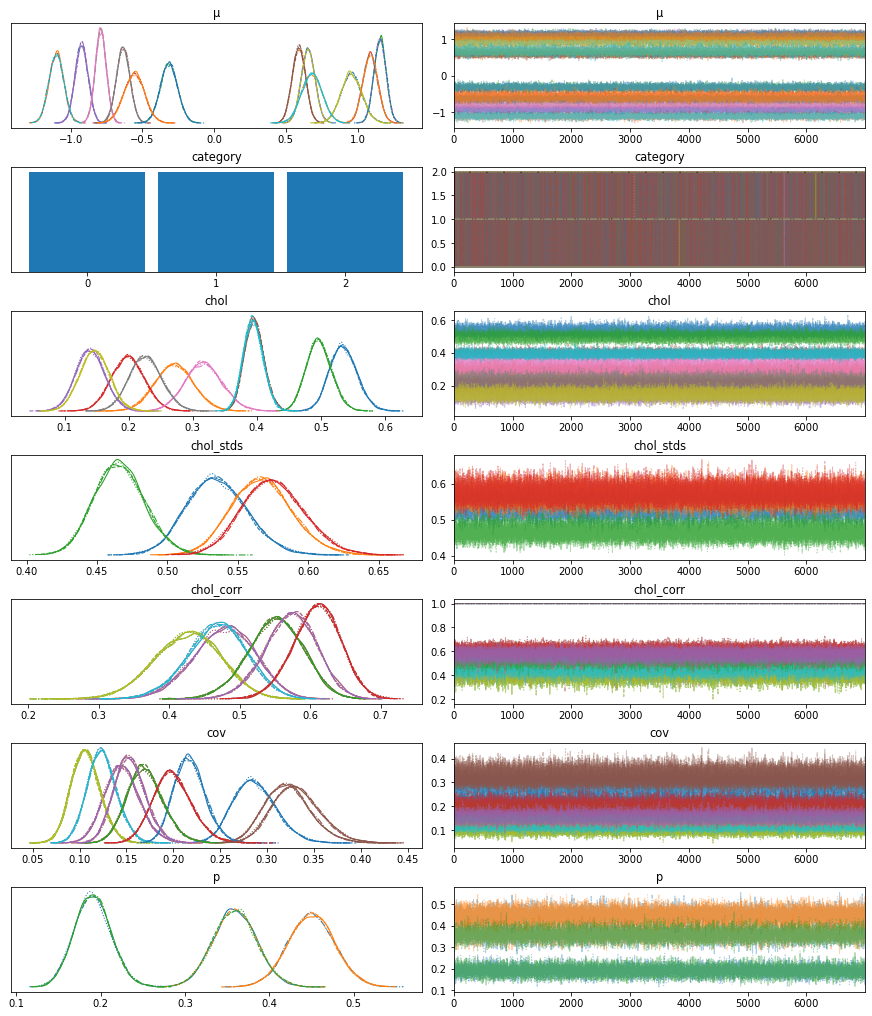

<IPython.core.display.Javascript object>

In [8]:
with model:
    pm.plot_trace(trace[1000:])

In [9]:
groups = [
    f"Group {n+1}"
    for n in list(trace.get_values("category", burn=1000, combine=False)[2][1000])
]
penguin_df["group"] = groups
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,group
0,Adelie,39.1,18.7,181.0,3750.0,Group 2
1,Adelie,39.5,17.4,186.0,3800.0,Group 2
2,Adelie,40.3,18.0,195.0,3250.0,Group 2
4,Adelie,36.7,19.3,193.0,3450.0,Group 2
5,Adelie,39.3,20.6,190.0,3650.0,Group 2
...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,Group 3
340,Gentoo,46.8,14.3,215.0,4850.0,Group 3
341,Gentoo,50.4,15.7,222.0,5750.0,Group 3
342,Gentoo,45.2,14.8,212.0,5200.0,Group 3


<IPython.core.display.Javascript object>

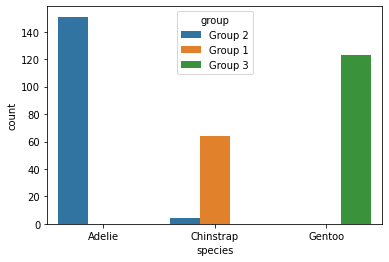

<IPython.core.display.Javascript object>

In [10]:
plot_df = (
    penguin_df.groupby(["species", "group"])
    .count()[["culmen_length_mm"]]
    .reset_index()
    .rename(columns={"culmen_length_mm": "count"})
)

_ = sns.barplot(data=plot_df, x="species", y="count", hue="group")

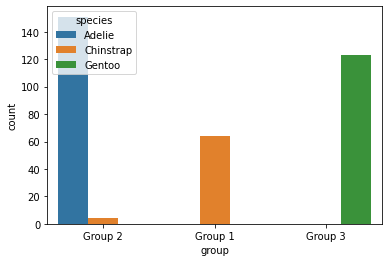

<IPython.core.display.Javascript object>

In [11]:
_ = sns.barplot(data=plot_df, x="group", y="count", hue="species")

In [12]:


alt.Chart(plot_df).mark_bar().encode(
    x=alt.X('group', title=None),
    y=alt.Y('count', title='Count'),
    color=alt.Color('species', title='Species'),
    tooltip=['group', 'count', 'species']
).properties(width=400)


alt.Chart(...)

<IPython.core.display.Javascript object>

This is an even better separation than the previous model, and while it is (for me) difficult to grok what exactly is happening you can't argue with these results.

## Detemining the optimal number of clusters

This was done in the very first notebook, but this version will be easier (there is only one likelihood) and this is a better model. So let's create a function that builds a model where the number of clusters can be set using a parameter.

In [13]:
def run_model(data, n_clusters, samples=4000):
    print(f"Building model with {n_clusters} cluster and {samples} samples.")

    n_observations, n_features = data.shape
    with pm.Model() as model:
        chol, corr, stds = pm.LKJCholeskyCov(
            "chol",
            n=n_features,
            eta=2.0,
            sd_dist=pm.Exponential.dist(1.0),
            compute_corr=True,
        )
        cov = pm.Deterministic("cov", chol.dot(chol.T))
        μ = pm.Normal(
            "μ", 0.0, 1.5, shape=(n_clusters, n_features), testval=data.mean(axis=0)
        )

        p = pm.Dirichlet("p", a=np.ones(n_clusters))
        category = pm.Categorical("category", p=p, shape=n_observations)

        obs = pm.MvNormal("obs", μ[category], chol=chol, observed=data)

        trace = pm.sample(samples)
    return model, trace

<IPython.core.display.Javascript object>

In [14]:
data = scaled_penguin_df.drop(columns=["species"]).values
model_traces = {
    f"model_{i}_clusters": run_model(data, i, samples=8000) for i in range(2, 6)
}

Building model with 2 cluster and 8000 samples.


<ipython-input-13-d7d8670ef98e>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>BinaryGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 703 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Building model with 3 cluster and 8000 samples.


<ipython-input-13-d7d8670ef98e>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 977 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Building model with 4 cluster and 8000 samples.


<ipython-input-13-d7d8670ef98e>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 1053 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Building model with 5 cluster and 8000 samples.


<ipython-input-13-d7d8670ef98e>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 1066 seconds.
The acceptance probability does not match the target. It is 0.8813733210852167, but should be close to 0.8. Try to increase the number of tuning steps.
There were 566 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3973 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32916311556026134, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873762723427782, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [15]:
comp = az.compare({k: v[1] for k, v in model_traces.items()})
comp

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\numpy\core\_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\a

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_3_clusters,0,-905.740656,68.837020,0.000000,4.808971e-01,29.476505,0.000000,True,log
model_5_clusters,1,-905.837578,197.606731,0.096921,5.191029e-01,28.926480,11.295538,True,log
model_4_clusters,2,-922.262126,175.651671,16.521469,0.000000e+00,29.039549,10.030136,True,log
model_2_clusters,3,-1284.311894,156.435489,378.571238,2.416753e-09,28.624421,16.756834,True,log


<IPython.core.display.Javascript object>

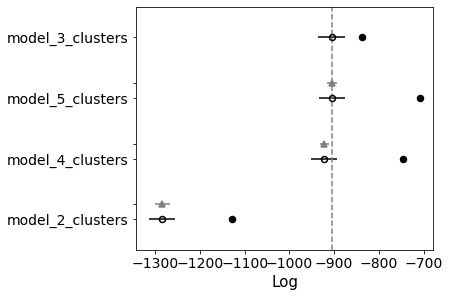

<IPython.core.display.Javascript object>

In [16]:
import matplotlib.pyplot as plt

az.plot_compare(comp)

plt.savefig("./docs/cluster_selection.png", dpi=300)
plt.show()

So this plot shows that there is no real difference in fit between the models with 3, 4, and 5 clusters (which one is ranked higher depends a little on randomness during sampling). So we have to choose the model with the fewest clusters, which also fits the number of species in the dataset, succes !

In [23]:
import gzip, pickle


def pickle_model(output_path: str, model, trace):
    """Pickles PyMC3 model and trace"""
    with gzip.GzipFile(output_path, "wb") as file:
        file.write(pickle.dumps({"model": model, "trace": trace}))


pickle_model(
    "./models/penguins_3_clusters.pickle.gz",
    model_traces["model_3_clusters"][0],
    model_traces["model_3_clusters"][1],
)

<IPython.core.display.Javascript object>